# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Utils

In [2]:
def bootstrap_difference_of_means(
    treatment,
    control,
    bootstrap_n=10_000,
):

    bootstrap_results = []

    for iter in range(bootstrap_n):
        bootstrap_results.append(
            np.mean(np.random.choice(treatment, size=len(treatment), replace=True))
            - np.mean(np.random.choice(control, size=len(control), replace=True))
        )

    return bootstrap_results


def permutation_test_difference_of_means(
    treatment,
    control,
    permutation_n=10_000,
):

    permutation_results = []

    for iter in range(permutation_n):
        combined = np.random.permutation(np.concatenate([treatment, control]))
        treatment_combined = combined[:len(treatment)]
        control_combined = combined[len(treatment):]
        permutation_results.append(
            np.mean(treatment_combined) - np.mean(control_combined)
        )

    return permutation_results

# Generate data

In [3]:
np.random.seed(1)
control_distribution = np.concatenate([np.zeros(100_000), 5 + np.random.beta(a=1, b=9, size=100_000) * 150])
treatment_distribution = control_distribution * 1.05
np.random.seed(1); control_sample = np.random.choice(control_distribution, size=5_000, replace=False)
np.random.seed(1); treatment_sample = np.random.choice(treatment_distribution, size=5_000, replace=False)

# Compute

In [4]:
permutation_results = permutation_test_difference_of_means(
    treatment=treatment_sample,
    control=control_sample,
)

In [5]:
bootstrap_results = bootstrap_difference_of_means(
    treatment=treatment_sample,
    control=control_sample
)

In [6]:
observed_difference = np.mean(treatment_sample) - np.mean(control_sample)

In [7]:
p_larger_than_observed = np.mean(np.array(permutation_results) >= observed_difference)
two_tailed_p_value = 2 * p_larger_than_observed

In [8]:
confidence = 0.95
ci_lower_bound = np.percentile(bootstrap_results, (1 - confidence) / 2 * 100)
ci_upper_bound = np.percentile(bootstrap_results, (1 - (1 - confidence) / 2) * 100)

In [9]:
# assuming 1 million customer per month
bootstrap_impact = np.array(bootstrap_results) * 1_000_000 * 12
bootstrap_impact_negative_mean = bootstrap_impact[bootstrap_impact < 0].mean()
bootstrap_impact_negative_prob = (bootstrap_impact < 0).mean()
bootstrap_impact_positive_mean = bootstrap_impact[bootstrap_impact >= 0].mean()
bootstrap_impact_positive_prob = (bootstrap_impact >= 0).mean()

# Print

In [10]:
print("mean of control distribution:", np.mean(control_distribution))
print("mean of treatment distribution:", np.mean(treatment_distribution))
print("observed difference: ", observed_difference)
print("p larger than observed: ", p_larger_than_observed)
print("two tailed p value:", two_tailed_p_value)
print("confidence interval lower bound", ci_lower_bound)
print("confidence interval upper bound", ci_upper_bound)

mean of control distribution: 9.998912672346675
mean of treatment distribution: 10.498858305964012
observed difference:  0.49245097397975
p larger than observed:  0.0403
two tailed p value: 0.0806
confidence interval lower bound -0.05639176485898825
confidence interval upper bound 1.0423161985865796


# Plots

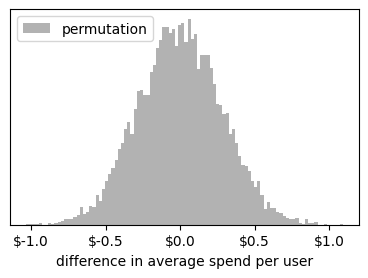

In [11]:
fig, ax = plt.subplots(figsize=(4.5, 2.8))

hist = ax.hist(permutation_results, bins=100, color="grey", alpha=.6, label="permutation")
ax.set_xlabel("difference in average spend per user")
ax.set_yticks([])
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_xticklabels([f"${x:.2}" for x in np.linspace(-1, 1, 5)])
ax.legend(loc="upper left")

fig.savefig("permutation_no_text.png", dpi=200, bbox_inches="tight");

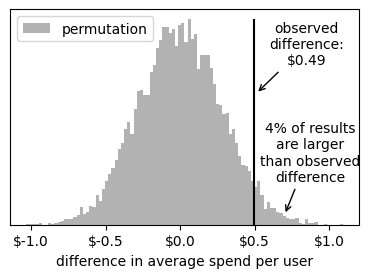

In [12]:
fig, ax = plt.subplots(figsize=(4.5, 2.8))

hist = ax.hist(permutation_results, bins=100, color="grey", alpha=.6, label="permutation")
ax.annotate(
    f"observed\ndifference:\n${observed_difference:.2}",
    xy=(.51, 200),
    xycoords="data",
    xytext=(.85, 275),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)
ax.annotate(
    f"{p_larger_than_observed:.0%} of results\nare larger\nthan observed\ndifference",
    xy=(.7, 15),
    xycoords="data",
    xytext=(.87, 110),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)
ax.vlines(observed_difference, 0, hist[0].max(), lw=1.5, color="black")
ax.set_xlabel("difference in average spend per user")
ax.set_yticks([])
ax.set_xticks(np.linspace(-1, 1, 5))
ax.set_xticklabels([f"${x:.2}" for x in np.linspace(-1, 1, 5)])
ax.legend(loc="upper left")

fig.savefig("permutation_with_text.png", dpi=200, bbox_inches="tight");

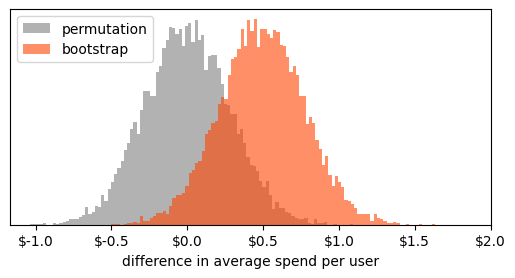

In [13]:
fig, ax = plt.subplots(figsize=(6.2, 2.8))

hist = ax.hist(permutation_results, bins=100, color="grey", alpha=.6, label="permutation")
hist = ax.hist(bootstrap_results, bins=100, color="orangered", alpha=.6, label="bootstrap")

ax.set_xlabel("difference in average spend per user")
ax.set_yticks([])
ax.set_xticks(np.linspace(-1, 2, 7))
ax.set_xticklabels([f"${x:.2}" for x in np.linspace(-1, 2, 7)])
ax.set_xlim(None, 2)
ax.legend(loc="upper left")

fig.savefig("bootstrap_no_text.png", dpi=200, bbox_inches="tight");

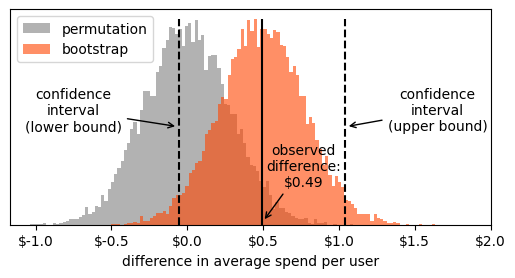

In [14]:
fig, ax = plt.subplots(figsize=(6.2, 2.8))

hist = ax.hist(permutation_results, bins=100, color="grey", alpha=.6, label="permutation")
hist = ax.hist(bootstrap_results, bins=100, color="orangered", alpha=.6, label="bootstrap")
ax.vlines(observed_difference, 0, hist[0].max(), lw=1.5, color="black")
ax.vlines(ci_lower_bound, 0, hist[0].max(), ls="--", lw=1.5, color="black")
ax.vlines(ci_upper_bound, 0, hist[0].max(), ls="--", lw=1.5, color="black")

ax.annotate(
    f"observed\ndifference:\n${observed_difference:.2}",
    xy=(.5, 5),
    xycoords="data",
    xytext=((observed_difference + ci_upper_bound) / 2, 90),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)

ax.annotate(
    f"confidence\ninterval\n(lower bound)",
    xy=(ci_lower_bound-.005, 150),
    xycoords="data",
    xytext=(-.75, 175),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)

ax.annotate(
    f"confidence\ninterval\n(upper bound)",
    xy=(ci_upper_bound+.005, 150),
    xycoords="data",
    xytext=(1.65, 175),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)

ax.set_xlabel("difference in average spend per user")
ax.set_yticks([])
ax.set_xticks(np.linspace(-1, 2, 7))
ax.set_xticklabels([f"${x:.2}" for x in np.linspace(-1, 2, 7)])
ax.set_xlim(None, 2)
ax.legend(loc="upper left")

fig.savefig("bootstrap_with_text.png", dpi=200, bbox_inches="tight");

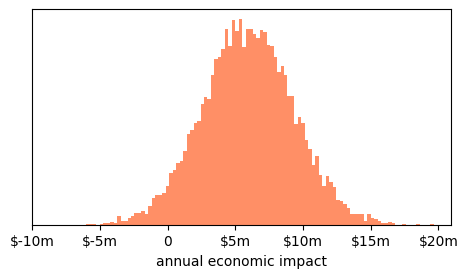

In [15]:
fig, ax = plt.subplots(figsize=(5.4, 2.8))

hist = ax.hist(bootstrap_impact, bins=100, color="orangered", alpha=.6)

ax.set_xlabel("annual economic impact")
ax.set_xticks(np.linspace(-10, 20, 7) * 1_000_000)
ax.set_yticks([])
ax.set_xticklabels([f"${int(x/1_000_000)}m" if x != 0 else int(x) for x in np.linspace(-10, 20, 7) * 1_000_000])

fig.savefig("annual_economic_impact_no_text.png", dpi=200, bbox_inches="tight");

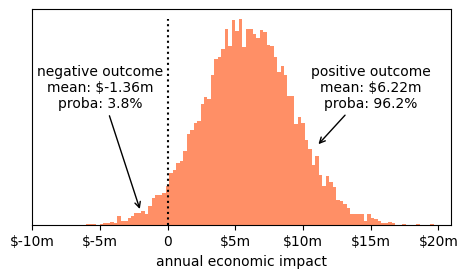

In [16]:
fig, ax = plt.subplots(figsize=(5.4, 2.8))

hist = ax.hist(bootstrap_impact, bins=100, color="orangered", alpha=.6)
ax.vlines(0, 0, hist[0].max(), ls=":", lw=1.5, color="black")

text = f"""\
negative outcome
mean: ${bootstrap_impact_negative_mean/1_000_000:.3}m
proba: {bootstrap_impact_negative_prob:.1%}"""

ax.annotate(
    text,
    xy=(-2_000_000, 20),
    xycoords="data",
    xytext=(-5_000_000, hist[0].max() * .67),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)

text = f"""\
positive outcome
mean: ${bootstrap_impact_positive_mean/1_000_000:.3}m
proba: {bootstrap_impact_positive_prob:.1%}"""

ax.annotate(
    text,
    xy=(11_000_000, 120),
    xycoords="data",
    xytext=(15_000_000, hist[0].max() * .67),
    textcoords="data",
    arrowprops=dict(arrowstyle="->", lw=1),
    ha="center",
    va="center",
)

ax.set_xlabel("annual economic impact")
ax.set_xticks(np.linspace(-10, 20, 7) * 1_000_000)
ax.set_yticks([])
ax.set_xticklabels([f"${int(x/1_000_000)}m" if x != 0 else int(x) for x in np.linspace(-10, 20, 7) * 1_000_000])

fig.savefig("annual_economic_impact_with_text.png", dpi=200, bbox_inches="tight");

# Reshape figures

In [17]:
import PIL

def pad_or_crop_image(input_path, target_size, output_path):
    # Open the image
    img = PIL.Image.open(input_path)

    # Get original dimensions
    original_width, original_height = img.size

    # Target dimensions
    target_width, target_height = target_size

    # Set target size to original size if None is passed for that dimension
    if target_width is None:
        target_width = original_width
    if target_height is None:
        target_height = original_height

    # Crop if target size is smaller than the original
    if target_width < original_width or target_height < original_height:
        # Calculate cropping box
        left = (original_width - target_width) // 2
        top = (original_height - target_height) // 2
        right = left + target_width
        bottom = top + target_height
        img = img.crop((left, top, right, bottom))

    # After cropping, recheck the new dimensions
    new_width, new_height = img.size

    # If needed, pad the image to target size
    if new_width < target_width or new_height < target_height:
        padding_left = (target_width - new_width) // 2
        padding_top = (target_height - new_height) // 2
        padding_right = target_width - new_width - padding_left
        padding_bottom = target_height - new_height - padding_top

        # Add padding
        img = PIL.ImageOps.expand(img, border=(padding_left, padding_top, padding_right, padding_bottom), fill='white')

    # Save the final image
    img.save(output_path, format='PNG')

In [18]:
imgs = [
    "permutation_no_text.png",
    "permutation_with_text.png",
    "bootstrap_no_text.png",
    "bootstrap_with_text.png",
    "annual_economic_impact_no_text.png",
    "annual_economic_impact_with_text.png",
]

max_img_width = 0

for img in imgs:
    img_width = PIL.Image.open(img).size[0]
    max_img_width = max(max_img_width, img_width)

for img in imgs:
    pad_or_crop_image(img, (1031, None), f"edit_{img}")